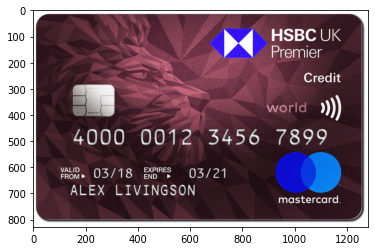

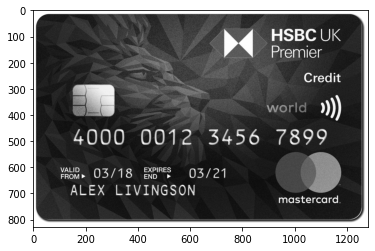

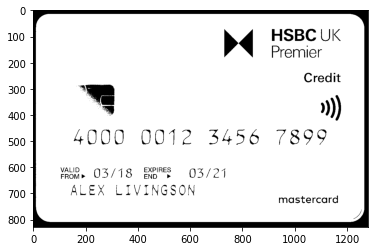

[[ 0 60 60 ... 60  1  0]
 [ 0 60 60 ... 60 60  0]
 [60 60 60 ... 60 60 60]
 ...
 [ 2 60 60 ... 60 60 60]
 [ 0 60 60 ... 60 60  0]
 [ 0  1 60 ... 60 32  0]]


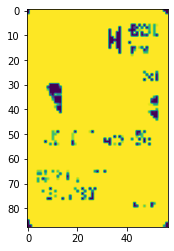

[(217, 107, 47, 13), (157, 106, 47, 14), (96, 106, 47, 15), (36, 106, 47, 14)]


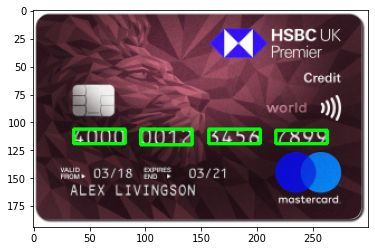

In [3]:
from imutils import contours
import numpy as np
import argparse
import imutils
import matplotlib.pyplot as plt
import cv2

ref = cv2.imread('./images/1.jpg')
# print(ref)
plt.imshow(ref)
plt.show()

ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
plt.imshow(ref,cmap='gray')
plt.show()
ref = cv2.threshold(ref, 200, 60, cv2.THRESH_BINARY_INV)[1]
plt.imshow(ref,cmap='gray')
plt.show()

# find contours in the OCR-A image (i.e,. the outlines of the digits)
refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
refCnts = imutils.grab_contours(refCnts)
refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]
digits = {}

for (i, c) in enumerate(refCnts):
    # compute the bounding box for the digit, extract it, and resize
    # it to a fixed size
    (x, y, w, h) = cv2.boundingRect(c)
    roi = ref[y:y + h, x:x + w]
    roi = cv2.resize(roi, (57, 88))
    # update the digits dictionary, mapping the digit name to the ROI
    print(roi)
    digits[i] = roi
    
plt.imshow(roi)
plt.show()
    
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

image = cv2.imread('./images/1.jpg')
image = imutils.resize(image, width=300)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)

gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0,
	ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")

gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# apply a second closing operation to the binary image, again
# to help close gaps between credit card number regions
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)


cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
locs = []


# get BB
for (i, c) in enumerate(cnts):
	(x, y, w, h) = cv2.boundingRect(c)
	ar = w / float(h)
	if ar > 2.5 and ar < 4.0:
		if (w > 40 and w < 55) and (h > 10 and h < 20):
			locs.append((x, y, w, h))
            

image = cv2.imread('./images/1.jpg')
image = imutils.resize(image, width=300)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

print(locs)

cv2.rectangle(image,locs[0],(0,255,0),2)
cv2.rectangle(image,locs[1],(0,255,0),2)
cv2.rectangle(image,locs[2],(0,255,0),2)
cv2.rectangle(image,locs[3],(0,255,0),2)

plt.imshow(image,cmap='gray')
plt.show()

In [4]:
locs = sorted(locs, key=lambda x:x[0])
output = []
print(locs[0])
print(locs)

(36, 106, 47, 14)
[(36, 106, 47, 14), (96, 106, 47, 15), (157, 106, 47, 14), (217, 107, 47, 13)]


In [5]:
groupOutput = []
# loop over the 4 groupings of 4 digits
for (i, (gX, gY, gW, gH)) in enumerate(locs):
    # initialize the list of group digits
    print(i)
    # extract the group ROI of 4 digits from the grayscale image,
    # then apply thresholding to segment the digits from the
    # background of the credit card
    group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
    group = cv2.threshold(group, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # detect the contours of each individual digit in the group,
    # then sort the digit contours from left to right
    digitCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    digitCnts = imutils.grab_contours(digitCnts)
    digitCnts = contours.sort_contours(digitCnts, method="left-to-right")[0]
#     groupOutput.append(digitCnts)

0
1
2
3


In [6]:
# loop over the digit contours
for c in digitCnts:
    # compute the bounding box of the individual digit, extract
    # the digit, and resize it to have the same fixed size as
    # the reference OCR-A images
    (x, y, w, h) = cv2.boundingRect(c)
    roi = group[y:y + h, x:x + w]
    roi = cv2.resize(roi, (57, 88))
    # initialize a list of template matching scores	
    scores = []
    # loop over the reference digit name and digit ROI
    for (digit, digitROI) in digits.items():
        # apply correlation-based template matching, take the
        # score, and update the scores list
        result = cv2.matchTemplate(roi, digitROI,
            cv2.TM_CCOEFF)
        (_, score, _, _) = cv2.minMaxLoc(result)
        scores.append(score)
    # the classification for the digit ROI will be the reference
    # digit name with the *largest* template matching score
    print(str(np.argmax(scores)))
    groupOutput.append(str(np.argmax(scores)))
        # draw the digit classifications around the group
#     cv2.rectangle(image, (gX - 5, gY - 5),
#         (gX + gW + 5, gY + gH + 5), (0, 0, 255), 2)
#     cv2.putText(image, "".join(groupOutput), (gX, gY - 15),
#         cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)
    # update the output digits list
    output.extend(groupOutput)
# print(groupOutput)

# define a dictionary that maps the first digit of a credit card
# number to the credit card type
FIRST_NUMBER = {
	"3": "American Express",
	"4": "Visa",
	"5": "MasterCard",
	"6": "Discover Card"
}

# display the output credit card information to the screen
# print("Credit Card Type: {}".format(FIRST_NUMBER[output[0]]))
# print("Credit Card #: {}".format("".join(output)))
# cv2.imshow("Image", image)
# cv2.waitKey(0)

0
0
0
0


In [7]:
image = cv2.imread('./images/1.jpg')
blank_image = np.zeros((100,100,1), np.uint8)
image = imutils.resize(image, width=300)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.drawContours(blank_image,groupOutput[2],-1,(1),1)
plt.imshow(blank_image,cmap='gray')
plt.show()

TypeError: Expected Ptr<cv::UMat> for argument 'contours'